<a href="https://colab.research.google.com/github/NicholasDow/Folder-of-Fail/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import seaborn as sns
import re
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go
import seaborn as sns
import re
from collections import Counter
import datetime
warnings.filterwarnings('ignore')

def oneway_anova(cats, dep):
    vals = []
    for cat in df[cats].dropna().unique():
        val = df[df[cats] == cat][dep].dropna()
        vals.append(val)
    return f_oneway(*vals)

def corr_plot(df):
    # use the pands .corr() function to compute pairwise correlations for the dataframe
    corr = df.corr()
    # visualise the data with seaborn
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    sns.set_style(style = 'white')
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(10, 250, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, center=0,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

def get_pvalues(df, factors):
    for f in factors:
        if f == 'total_deaths_per_million':
            continue
        df_f = df[['total_deaths_per_million', f]].dropna()
        # Train model for t test
        model = smf.ols('total_deaths_per_million ~' + f, data=df_f).fit()
        # Results
        if model.pvalues[1] < 0.05:
            print('p-value for {} = {:4f}'.format(f, model.pvalues[1])) 

def linear_reg(df, factors, dep='total_deaths_per_million'):
    for f in factors:
        df_f = df[['location', 'continent', dep, f]].dropna()

        fig = px.scatter(df_f, x=f, y=dep, color = 'continent',
                         hover_data=['location'], width=600, height=400,
                         labels={dep: dep.replace('_', ' ').capitalize() + ' population',
                                 f: f.replace('_', ' ').capitalize()} )

        # Linear regression
        X = df_f[f].values.reshape(-1,1)
        y = df_f[dep].values.reshape(-1,1)

        reg = LinearRegression()
        reg.fit(X, y)
        y_pred = reg.predict(X)
        fig.add_trace(
            go.Scatter(
            x=X.flatten(),
            y=y_pred.flatten(),
            mode="lines",
            line=go.scatter.Line(color="red"),
            showlegend=False))
        fig.show()



In [ ]:
#@title
if 'google.colab' in str(get_ipython()):
  location = 'drive/MyDrive/citadel_datathon/provided_data/'
else:
  location = 'provided_data/'
count = 0
files = {}
for foldername in os.listdir(location):
  for filename in os.listdir(location + foldername):
    files[str(count) +'-'+ foldername + '-' + filename[:-4]] = pd.read_csv(os.path.join(location,foldername,filename)) 
    count += 1
keys = list(files.keys())

owid = files[keys[7]]
df = files[keys[0]]
ocd = owid.copy()


# What Makes a country vulnerable to Covid-19 and what response measures can help?

Authors: Hao-Li Huang, Nicholas Dow, Johnson Wu <br>
Team 22, Boston Regional Datathon

### _Preface_

Working remotely can be hard, and working remotely with new people for the first time is even harder.

\

I enjoyed working with my teammates and learned a lot from them while doing the Citadel Datathon. I feel as though I learned a lot through the discussion about bias, causality, and my teammates' insights in their EDA. Despite not being able to fully flesh out the project.

\

Most of what we have here are things stitched together from our EDA. Ultimately we couldn't make the model we wanted to run in time, so we propose the model at the end.

# Question Formation

Our team took a data-first approach. We started by doing a great deal of exploratory data analysis to look for quirks in the data that we could form a question around. Ultimately our question became: 

\

## “What made a country vulnerable to the pandemic, and which response policies are effective in that they might help a vulnerable country” 

\

Though our question was generic -- in hindsight, it is similar to ‘Sample Question 1’ -- we chose this question because of our data-first approach and because we thought that any insight into this question could meaningfully help those people who were most vulnerable.

\

The formation of the question started when we noticed the European CDC data was detailed in when and what response policies were implemented in various European countries. We reckoned that in a post-vaccine world understanding what response policies worked might be important for vulnerable countries that might have no choice but to use non-pharmaceutical methods.


In [ ]:
#@title
print('Response Measure data we were interested in')
files[keys[0]].sample(5)

Response Measure data we were interested in


,Country,Response_measure,date_start,date_end
558,Hungary,StayHomeOrderPartial,2020-11-04,NaN
1095,Romania,MassGather50,2020-09-01,NaN
359,Finland,IndoorOver50,2020-10-15,NaN
1144,Slovakia,MassGather50Partial,2020-11-02,2020-11-14
610,Ireland,ClosureOfPublicTransportPartial,2020-03-27,2020-06-05


In [ ]:
#@title
print('Wide column global data we used')
print('shape of columns', files[keys[7]].shape)
print('Notice not all 52 columns are showing here')
files[keys[7]].sample(5).iloc[:,:7]

Wide column global data we used
shape of columns (58154, 52)
Notice not all 52 columns are showing here


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed
26714,JPN,Asia,Japan,2020-12-14,182311.0,1672.0,2553.857
13920,COD,Africa,Democratic Republic of Congo,2020-05-30,2966.0,133.0,134.429
3319,AZE,Asia,Azerbaijan,2020-08-28,35986.0,142.0,152.143
44767,STP,Africa,Sao Tome and Principe,2020-08-17,885.0,0.0,1.000
50968,SYR,Asia,Syria,2021-01-03,11710.0,94.0,96.714


# What makes a country vulnerable to Covid-19?


Over the course of the Covid-19 pandemic, it became clear that some countries are hit harder than others, but why? It may be surprising to some that the countries suffer the most are mostly the wealthy western countries that should have adequate resources to react to the virus. We wanted to identify important factors which vulnerable countries share in common. The insights gained from our analyses would be a valuable information to have to better prepare for a possible future pandemic.

We use the `owid` dataset to explore the question posted above. We first need to identify a indicator for the severeness of the pandemic in the countries. Thus, we check the percentage of missing values in each given column.

In [ ]:
owid.isna().mean()

iso_code                              0.005726
continent                             0.011727
location                              0.000000
date                                  0.000000
total_cases                           0.009337
new_cases                             0.009458
new_cases_smoothed                    0.025880
total_deaths                          0.152457
new_deaths                            0.152474
new_deaths_smoothed                   0.025880
total_cases_per_million               0.015063
new_cases_per_million                 0.015184
new_cases_smoothed_per_million        0.031520
total_deaths_per_million              0.157960
new_deaths_per_million                0.157977
new_deaths_smoothed_per_million       0.031520
reproduction_rate                     0.226279
icu_patients                          0.895588
icu_patients_per_million              0.895588
hosp_patients                         0.882536
hosp_patients_per_million             0.882536
weekly_icu_ad

The Covid-19 pandemic disrupts our daily life because it can potentially cause people to seriously ill or even die. We would have chosen `icu_patients_per_million` as our indicator. However, most values in those columns are missing, so we end up using `total_deaths_per_million`, which is also a very important indicator. 
<br><br>
In this analysis, we specifically look at the cumulative `total_deaths_per_million` 300 days after the first case was reported in the country. 
<br><br>
And then, because a low case count might due to insufficient testing, we filter out the entries with the 15% lowest `new_cases_smoothed_per_million` and a `new_tests_smoothed_per_thousand` that is less than 0.5.

In [ ]:
# Add some features
owid['death_per_case'] = owid['total_deaths'] / owid['total_cases']
owid['max_new_cases_smoothed_per_million'] = owid.groupby('location')[
    'new_cases_smoothed_per_million'].transform(max)

# We should probably take into account the date the virus entered the country
# --> 300 days after first case
owid['date'] = pd.to_datetime(owid['date'])
owid['first_case_date'] = owid.groupby('location')['date'].transform(min)
owid['days_from_first_case'] = owid['date'] - owid['first_case_date']
df = owid[owid['days_from_first_case'] == pd.Timedelta(300, unit = 'days')].copy()

# Filter out low case numbers originating from few testings
df['new_cases_rank'] = df['new_cases_smoothed_per_million'].rank(pct=True)
df['new_tests_smoothed_per_thousand'] = df['new_tests_smoothed_per_thousand'].fillna(-1)
df = df[~((df['new_cases_rank'] < 0.15) & (df['new_tests_smoothed_per_thousand'] < 0.5))]

# Drop World and International
df = df[(df['location'] != 'World') & 
        (df['location'] !='International')].reset_index(drop=True)

# Some transformation
df['log_population'] = np.log(df['population'])
df['log_population_density'] = np.log(df['population_density'])
df['log_extreme_poverty'] = np.log(df['extreme_poverty'])

# Fill in some missing positive rates
df['positive_rate'] = df.apply(lambda row: row['positive_rate'] if 
                                not np.isnan(row['positive_rate'])
                                else row['new_cases_smoothed']/ row['new_tests_smoothed'], 
                                axis = 1)

We find that the distribution of `total_deaths_per_million` is very different in every continent, and the p value of a one-way ANOVA test is practically 0.

F_onewayResult(statistic=8.833082593481597, pvalue=7.743096042105841e-07)

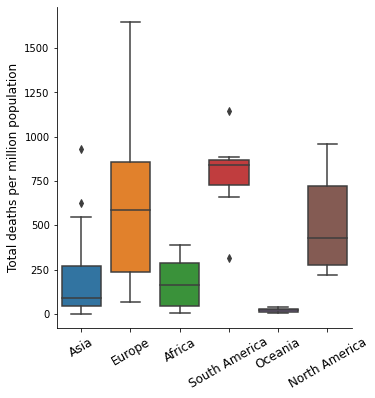

In [ ]:
# Total deaths per million by continent
g = sns.catplot(x='continent', y='total_deaths_per_million', data=df, kind='box')
g.set_xticklabels(rotation=30, fontsize=12);
g.ax.set_ylabel('Total deaths per million population', fontsize=12)
g.ax.set_xlabel('')
oneway_anova('continent', 'total_deaths_per_million')

We then go on and look at the information provided in the `owid` dataset. The columns are mostly information on demographic structure, so it may make sense for us to only look at the countries that have community spread, indicated by high case number per million.

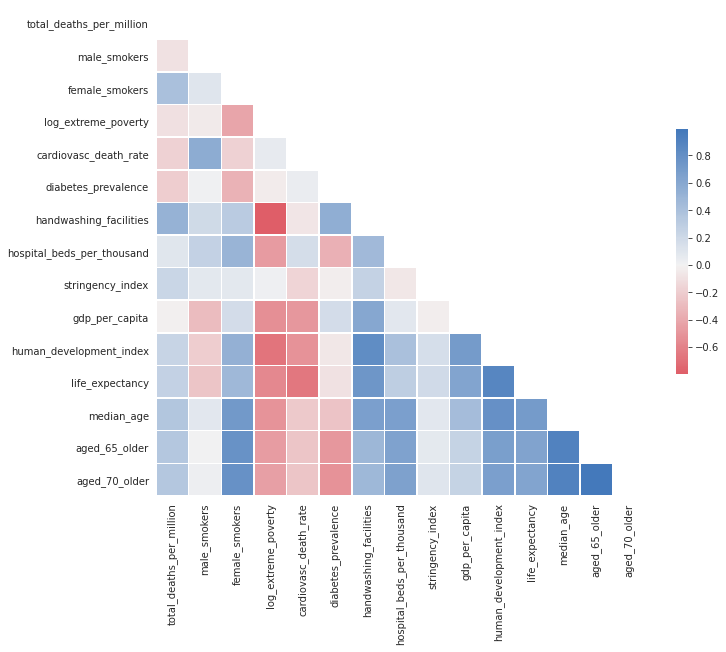

In [ ]:
# Only consider countries that have community spread (high case per million)
df1 = df[df['total_cases_per_million'] > 5000]

# Pair plot for features, data points colored according to continent
factors = ['total_deaths_per_million', 
           'male_smokers', 'female_smokers', 'log_extreme_poverty', 
           'cardiovasc_death_rate', 'diabetes_prevalence', 
           'handwashing_facilities', 'hospital_beds_per_thousand',
           'stringency_index','gdp_per_capita', 'human_development_index', 
           'life_expectancy', 'median_age', 'aged_65_older', 'aged_70_older']
df2 = df[factors]
corr_plot(df2)

We can quickly glance at the correlations between features. We see strong correlation between total deaths and total cases, which makes sense. We also see correlation between total deaths and aged_70_older. Let's go through all the features and run significant testings and calculate the p-values.

In [ ]:
get_pvalues(df1, factors)

p-value for female_smokers = 0.014979
p-value for diabetes_prevalence = 0.012023
p-value for median_age = 0.015494
p-value for aged_65_older = 0.003782
p-value for aged_70_older = 0.004734


In [ ]:
linear_reg(df1, ['aged_65_older'])

The high `aged_65_older` correlates to higher total deaths, which is not surprising because it has been established that older people are more vulnerable to the virus. 
<br><br>
The reason why the percentage of `female_smokers` is also highly correlated with total deaths is likely because it is highly correlated with `aged_65_older`, so we don't think there is a causality here. The other age factors (`median_age` & `aged_70_older`) are also highly correlated with `aged_65_older`, so later on we will only use `aged_65_older` as a feature.
<br><br>

# External dataset
After exploring the features provided in the `owid` dataset, we try to explore other features created using external datasets that might be important to the spread and control of the virus. We look at the following directions:

- Democracy index
- International tourism (arrival/departure)
- Country geography (island/Schengen/others)
- Leader gender

## 1. Democracy index
Source: https://en.wikipedia.org/wiki/Democracy_Index <br>
People in democratic countries may react differently to lockdown restrictions than those in a less democratic country. More democratic countries might take longer to settle on a policy and/or might not enforce the policies as strictly. Is there a correlation between the number of cases and the democracy index?
<br><br>
We scrape the data from the following Wikipedia page.

In [ ]:
df_dem = pd.read_html('https://en.wikipedia.org/wiki/Democracy_Index', match='Year 2020')[-1]
df_dem.columns = df_dem.columns.droplevel(1)
df_dem = df_dem[df_dem['Rank'].str.isdigit()].reset_index(drop = True)
df_dem = df_dem.drop(['Δ Rank', 'Δ Score'], axis = 1)
df_dem.loc[df_dem['Country'] == 'Czech Republic', 'Country'] = 'Czechia'
# Clean up column names
df_dem.columns = ['Rank', 'Country', 'Regime_type', 'Electoral_process_and_pluralism',
       'Functioning_of_government', 'Political_participation',
       'Political_culture', 'Civil_liberties', 'Overall_score']
# Turn columns from str to float
df_dem[['Electoral_process_and_pluralism',
       'Functioning_of_government', 'Political_participation',
       'Political_culture', 'Civil_liberties', 'Overall_score']] = df_dem[[
       'Electoral_process_and_pluralism',
       'Functioning_of_government', 'Political_participation',
       'Political_culture', 'Civil_liberties', 'Overall_score']].astype(float)
# Merge dataframes
df = pd.merge(df, df_dem, how = 'left', left_on = 'location', right_on = 'Country')

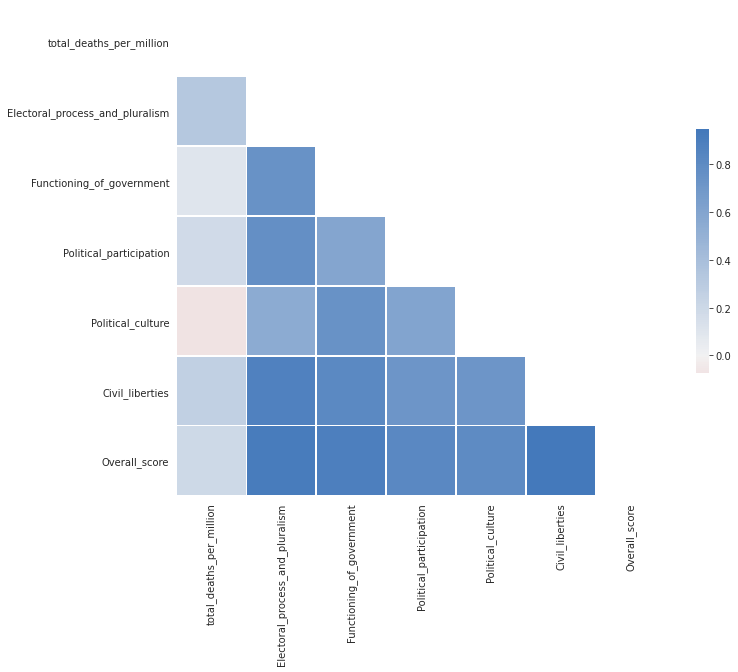

In [ ]:
corr_plot(df[['total_deaths_per_million','Electoral_process_and_pluralism',
       'Functioning_of_government', 'Political_participation',
       'Political_culture', 'Civil_liberties', 'Overall_score']])

In [ ]:
get_pvalues(df, ['Electoral_process_and_pluralism',
       'Functioning_of_government', 'Political_participation',
       'Political_culture', 'Civil_liberties', 'Overall_score'])

p-value for Electoral_process_and_pluralism = 0.001797
p-value for Civil_liberties = 0.013052


In [ ]:
linear_reg(df, ['Electoral_process_and_pluralism', 'Civil_liberties'])

Among the subcategories and the overall score, two are important to predict the total deaths. The first one is `Electoral_process_and_pluralism`. For a totalitarianism regime, which would have a low score here, it may impose a strict lockdown more effectively than a pluralism regime. The second subcategory is `Civil_liberties`, which may reflect the people's reactions to lockdown orders or recommendations from the governments.
<br><br>
It's interesting to note that the overall score is not as a good indicator than the two subcategories mentioned above, because one of the subcategories (`Political_cultures`) is slightly negatively correlated.

## 2. International tourism
Source: <br>
https://data.worldbank.org/indicator/ST.INT.ARVL <br>
https://data.worldbank.org/indicator/ST.INT.DPRT
<br><br>
Movement of people makes virus spread more easily. Here we use the international tourism data (number of arrival/departure per year) from a typical pre-covid year to get a sense of how many people go in and out a country.

In [ ]:
arr = pd.read_csv('/content/international_arrival.csv', header = 4).dropna(thresh = 5)
dep = pd.read_csv('/content/International_departure.csv', header = 4).dropna(thresh = 5)

# Function to get data from the latest year if the 2019 data is missing
def get_latest(row):
    year = 2019
    i = 0
    while np.isnan(row[str(year - i)]):
        i += 1
    return row[str(year - i)] 

arr['latest_arr'] = arr.apply(get_latest, axis=1)
dep['latest_dep'] = dep.apply(get_latest, axis=1)

# Merge data
df = pd.merge(df, arr[['Country Code', 'latest_arr']], 
         how = 'left', left_on = 'iso_code', right_on = 'Country Code')
df = pd.merge(df, dep[['Country Code', 'latest_dep']], 
         how = 'left', left_on = 'iso_code', right_on = 'Country Code')

# We normalize the arrival/departure numbers with the populations of the countries.
# The data distribution is skewed to the left, so we use a log transformation 
# to make the distribution more normal.
df['normalized_annual_arrival'] = np.log(df['latest_arr'] / df['population'])
df['normalized_annual_departure'] = np.log(df['latest_dep'] / df['population'])

In [ ]:
get_pvalues(df, ['normalized_annual_arrival', 'normalized_annual_departure'])

p-value for normalized_annual_arrival = 0.007984


In [ ]:
linear_reg(df, ['normalized_annual_arrival'])

Interestingly, only the arrival number, not the departure, is important.

## 3. Country geography
Source: <br>
https://en.wikipedia.org/wiki/List_of_island_countries <br>
https://en.wikipedia.org/wiki/Schengen_Area 
<br><br>
Country geography may indicate effectively border control can be imposed. Here, we categorize countries into three groups, islands, Schengen countries, and others. <br>
We get the lists of countries from the following Wikipedia pages.

In [ ]:
# List of island countries
island = pd.read_html('https://en.wikipedia.org/wiki/List_of_island_countries')[0]['Name']
island = island.apply(lambda n: n.split('[')[0])
island.iloc[42] = 'Taiwan'
island = pd.concat([island, pd.Series('Australia')]).reset_index(drop=True) # add Australia

# List of Schengen countries
Schengen = pd.read_html('https://en.wikipedia.org/wiki/Schengen_Area', 
                        match = 'Members of the Schengen area')[0]['State']
Schengen2 = pd.read_html('https://en.wikipedia.org/wiki/Schengen_Area', 
                        match = 'States which are not members')[0]['State']
Schengen = Schengen.apply(lambda n: n.split('[')[0].split('(')[0].strip())
Schengen.iloc[2] = 'Czechia'
Schengen = Schengen.drop(26)
Schengen = pd.concat([Schengen, Schengen2]).reset_index(drop=True)

# Function to categorize countries
def get_geo(row):
    if row['location'] in set(island):
        return 'Island'
    elif row['location'] in set(Schengen):
        return 'Schengen'
    else:
        return 'Others'

# Add geography column to df
df['geography'] = df.apply(get_geo, axis=1)    

F_onewayResult(statistic=6.957455572772102, pvalue=0.0015353704300056657)

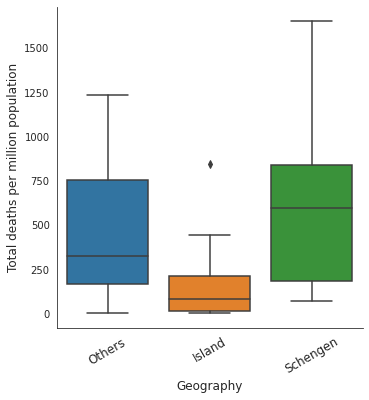

In [ ]:
# Total deaths per million by geography
g = sns.catplot(x='geography', y='total_deaths_per_million', data=df, kind='box')
g.set_xticklabels(rotation=30, fontsize=12);
g.ax.set_ylabel('Total deaths per million population', fontsize=12)
g.ax.set_xlabel('Geography',  fontsize=12)
oneway_anova('geography', 'total_deaths_per_million')

We see that islands have lower total deaths, whereas the Schengen countries have higher. According to the one-way ANOVA test, the three groups categorized by geography are significantly different.

## 4. Leader gender
Source: https://en.wikipedia.org/wiki/List_of_elected_and_appointed_female_heads_of_state_and_government <br>
Inspired by the NY Times article: https://www.nytimes.com/2020/05/15/world/coronavirus-women-leaders.html 
<br><br>
It was brought up by the NY Times that it seems like countries with female leaders seem to do better dealing with the pandemic, but is it statistcally significant?
<br>
The list of countries with female leaders is taken from the following Wikipedia page.

In [ ]:
url = 'https://en.wikipedia.org/wiki/' + \
         'List_of_elected_and_appointed_female_heads_of_state_and_government'
female_leaders = pd.read_html(url)[3]

# Change 'Incumbent' to today to be readable by to_datetime
female_leaders['Mandate end'] = female_leaders['Mandate end'].apply(
    lambda c: c if c != 'Incumbent' else '4 March 2021')
# Remove text following some dates
female_leaders['Mandate end'] = female_leaders['Mandate end'].apply(
    lambda c: re.findall('(\d{1,2} [A-Z][a-z]+ \d{4})', c)[0])
# to_datetime
female_leaders['Mandate start'] = pd.to_datetime(female_leaders['Mandate start'])
female_leaders['Mandate end'] = pd.to_datetime(female_leaders['Mandate end'])

# Keep the countries which have female leaders during at least Apr to Nov
female_leaders = female_leaders[
    (female_leaders['Mandate start'] < pd.to_datetime('1 April, 2020')) &
    (female_leaders['Mandate end'] > pd.to_datetime('1 December, 2020'))][
    'Country'].reset_index(drop=True)
female_leaders.iloc[6] = 'Taiwan'

# Function to categorize countries
def get_fl(row):
    if row['location'] in set(female_leaders):
        return 'Female leader'
    else:
        return 'Male leader'

df['leader'] = df.apply(get_fl, axis=1)

F_onewayResult(statistic=8.672415358011413, pvalue=0.004080970876520131)

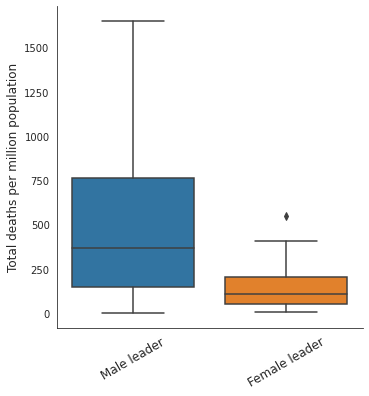

In [ ]:
# Total deaths per million by leader gender
g = sns.catplot(x='leader', y='total_deaths_per_million', data=df, kind='box')
g.set_xticklabels(rotation=30, fontsize=12);
g.ax.set_ylabel('Total deaths per million population', fontsize=12)
g.ax.set_xlabel('')
oneway_anova('leader', 'total_deaths_per_million')

It is indeed statistically significant according to the t-test. It is pointed out by the article that a female leader indicates a more diverse cabinet and potentially more robust decision making. A female leader also often signifies a mature and progressive society.
<br><br>
It is interesting to note that female leaders don't prevent the virus from spreading, according to the following figure. Thus, they likely manage the crisis well to keep the death rate low.

F_onewayResult(statistic=2.602739035972074, pvalue=0.11003149832114588)

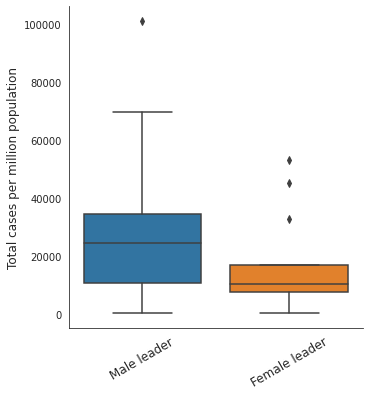

In [ ]:
g = sns.catplot(x='leader', y='total_cases_per_million', data=df, kind='box')
g.set_xticklabels(rotation=30, fontsize=12);
g.ax.set_ylabel('Total cases per million population', fontsize=12)
g.ax.set_xlabel('')
oneway_anova('leader', 'total_cases_per_million')

# Modeling

In this section, we will build a machine learning model to see how these features may predict the total deaths of countries. Because we have both numerical and categorical features, we choose a tree model for this task. We first use a decision tree regressor.

In [ ]:
# Keep only the important features
features = ['total_deaths_per_million', 'continent', 'aged_65_older', 
            'Civil_liberties', 'normalized_annual_arrival', 'geography', 'leader']
df_m = df[features]

We need to check the missing values.

In [ ]:
df_m.isna().sum()

total_deaths_per_million     1
continent                    0
aged_65_older                4
Civil_liberties              6
normalized_annual_arrival    1
geography                    0
leader                       0
dtype: int64

We decide to simply drop the row without the total deaths and impute the other columns with the median within the respective continent.

In [ ]:
# Drop the row without the total deaths
df_m = df_m[~ df_m['total_deaths_per_million'].isna()]

# For other columns, we impute the missing value with the median within 
# the respective continent
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

class GroupImputer(TransformerMixin):

    def __init__(self, target, group_cols = ['continent'], metric = 'median'):
        self.group_cols = group_cols
        self.target = target
        self.metric = metric
        
    def fit(self, X, y=None):
        self.impute_map_ = X.groupby(self.group_cols)[self.target].agg(
            self.metric).reset_index(drop=False)

        return self

    def transform(self, X, y=None):
        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind, self.target] = X.loc[ind, self.target].fillna(row[self.target])
        
        return X
    
# Data
X = df_m.drop('total_deaths_per_million', axis=1)
y = df_m['total_deaths_per_million']

# One hot encoder
categorical_features = ['continent', 'geography', 'leader']
numeric_features = ['aged_65_older', 'Civil_liberties', 'normalized_annual_arrival']

ohe = OneHotEncoder()
preprocessor = ColumnTransformer(transformers = [
    ('cat', ohe, categorical_features), 
    ('num', 'passthrough', numeric_features)])

First, for a sanity test, we check the scores for a dummy regressor. Note that we put the imputor in a pipeline to avoid data leakage in the later cross valilation step.

In [ ]:
# Check dummy regressor
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy())

### Pipeline: 
# 1. impute missing values 
# 2. one hot encoder for categorical features
# 3. dummy regressor
pipe_dum = Pipeline(steps = [('col1', GroupImputer('aged_65_older')),
                             ('col2', GroupImputer('Civil_liberties')),
                             ('col3', GroupImputer('normalized_annual_arrival')), 
                             ('ohe', preprocessor),
                             ('dummy', DummyRegressor(strategy = 'median'))])
pipe_dum.fit(X_train, y_train)

print('Dummy training score = {:3f}'.format(pipe_dum.score(X_train, y_train)))
print('Dummy test score = {:3f}'.format(pipe_dum.score(X_test, y_test)))

Dummy training score = -0.095813
Dummy test score = -0.113650


The dummy regressor outputs training and test scores that are close to zero. Having this as a baseline, we go on to use our data to train a gradient boosting regressor.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

### Pipeline: 
# 1. impute missing values 
# 2. one hot encoder for categorical features
# 3. gradient boosting regressor
# 4. grid search cv

gdb = GradientBoostingRegressor()

pipe = Pipeline(steps = [('col1', GroupImputer('aged_65_older')),
                         ('col2', GroupImputer('Civil_liberties')),
                         ('col3', GroupImputer('normalized_annual_arrival')), 
                         ('ohe', preprocessor),
                         ('gdb', gdb)])

param_grid = {'gdb__learning_rate': [0.09, 0.1, 0.11, 0.12, 0.13],
              'gdb__n_estimators': [21, 22, 23, 24, 25, 26, 27, 28],
              'gdb__max_depth': [3, 4]}

search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X, y)
print('Gradient boosting best parameter (CV score = {:3f}):'.format(search.best_score_))
print(search.best_params_)

Gradient boosting best parameter (CV score = 0.348238):
{'gdb__learning_rate': 0.11, 'gdb__max_depth': 3, 'gdb__n_estimators': 22}


The average CV score is improved from 0! We then use the best parameters to train the model, and plot out the feature importances. We train the model 10 times and take averages of the training scores, test scores, and feature importances.

In [ ]:
# Run gradient boosting using the best parameter 10 times 
# and record the feature importances
train_score, test_score, importances = [], [], []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy())

    gdb = GradientBoostingRegressor(max_depth = 3, 
                                    learning_rate = 0.11, 
                                    n_estimators = 25)

    pipe_gdb = Pipeline(steps = [('col1', GroupImputer('aged_65_older')),
                                 ('col2', GroupImputer('Civil_liberties')),
                                 ('col3', GroupImputer('normalized_annual_arrival')), 
                                 ('ohe', preprocessor),
                                 ('dtr', gdb)])

    pipe_gdb.fit(X_train, y_train)
    train_score.append(pipe_gdb.score(X_train, y_train))
    test_score.append(pipe_gdb.score(X_test, y_test))
    importances.append(gdb.feature_importances_)

print('training score = {:3f}'.format(np.mean(train_score)))
print('test score = {:3f}'.format(np.mean(test_score)))

training score = 0.806750
test score = 0.360718


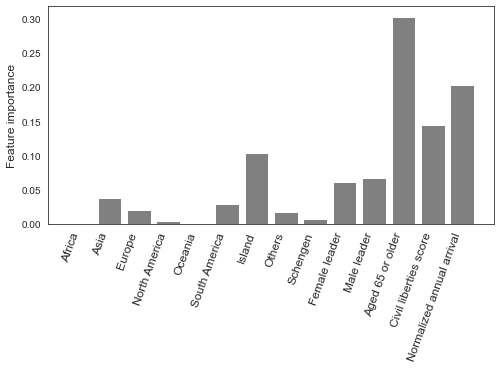

In [ ]:
# Plot feature importance
importance = np.mean(importances, axis=0)
fig, ax = plt.subplots(figsize=(8,4))
x = [i for i in range(len(importance))]
ax.bar(x, importance, align='center', color='grey')

xtick = list(ohe.fit(X_train[categorical_features]).categories_)
xtick.append(['Aged 65 or older', 'Civil liberties score', 'Normalized annual arrival'])
xtick = [item for sublist in xtick for item in sublist]

ax.set_ylabel('Feature importance', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(xtick, rotation=70, ha='right', fontsize=12);

The most important features to predict the total deaths per million population of a country are the age structure, annual tourism arrival (normalized by population), civil liberty score, country geography (especially island countries), and the gender of the leader.

# Conclusion
Therefore, we conclude that the most vulnerable countries likely have the following in common:
1. Population ageing. Larger share of the population is vulnerable to the virus.
2. Popular tourism destination. More international arrival makes it more likely for the virus to come into the country.
3. High civil liberty score. Democratic countries may be more reluctant to impose stringent policies to restrict people's movement, which is likely necessary to slow down the spread. 
4. Loose border control. The reason why island countries do better is likely because of a more effective border control.
5. Male leader. Female leaders likely signify a mature and progressive society, which may react better to the pandemic.

Two of the factors have to do with people traveling into the country, and two with the political culture. The former factors signifies the importance of stopping the virus at the border, which can be implemented by a strict 2-week quarantine upon entering the country. The latter factors capture the relationship between the citizens and the government, which is more nuanced. It is not surprising that people in democracy may not react well to strict stay-at-home orders, and democratic governments may thus be reluctant impose such orders. Thus, clear and transparent communication and timely implementation of supporting policies can be key to making people receive the policies better. 
<br><br>
Due to the time constraint, availability of the data, and the complex nature of this problem, we are not able to dig deeper into how exactly each feature impact on the total deaths number, we do have some educated guesses as explained above. We think it would be a good direction to go into for future studies. 

# Modeling which response policies are most effective 

Ultimately we had a very difficult time finding an explainable model for the purpose of testing the effectiveness of response measures. Policies overlapped and coincided. Using bayesian inference we might have been able to select the most effective response measure for a limited portion of the data. 

\

The problem gets further complicated by ambiguous causality as a result of different regions. As we observed with the diverging fortunes of Asia and Europe. 

\

We did not use SARIMAX or ARIMA but they were candidates for our model. The biggest issue was the ability to effectively incorporate the complex response measure data. But an additional issue with SARIMAX or ARIMA like with FACEBOOK PROPHET is that it really isn't very explainable. While these models can take a time series stream and a y value and predict the time series, it really blindly looks at the periodic time series trend. These models will do a decent job copying the daily fluctuations of covid numbers and deaths by pulling out the end/beginning of the week reporting habit of hospitals but will miss the diseases macrotrend which is the result of countries changing their approach to the pandemic. In the case where these models do really consider these things, the virus will have had to been allowed to go rampant in such a way that the susceptibility in the classic SIR model would have intensely changed.  

\

 We also considered using Difference in Difference, but this might have been the wrong model too. One big issue with the Difference in Difference model was that there were very few times when a country had no policies at all. We often looked at Sweden as a possible control for the models since they never seriously implemented a lockdown. 

\


# Processing for Response Measure Modeling

Inorder to even begin trying model anything, we need to group the countries and the policies. Not only to simplify things, but also to account for in group correlation 



### Response Measure Processing

We did this by eliminating partial measures, and manually catagorizing response measures by their severity and type.

In [ ]:
# 1. Revmove 'Partial'
df['Response_measure'] = [r.split('Partial')[0] for r in df['Response_measure']]
mapping = {'EntertainmentVenues': 'NonEssential',
           'GymsSportsCentres': 'NonEssential',
           'NonEssentialShops': 'NonEssential',
           'PlaceOfWorship': 'NonEssential', 
           'MassGatherAll': 'MassGather',
           'MassGather50': 'MassGather',
           'IndoorOver50': 'MassGather',
           'IndoorOver100': 'MassGather',
           'IndoorOver500': 'MassGather',
           'IndoorOver1000': 'MassGather',
           'OutdoorOver50': 'MassGather',
           'OutdoorOver100': 'MassGather',
           'OutdoorOver500': 'MassGather',
           'OutdoorOver1000': 'MassGather',
           'BanOnAllEvents': 'MassGather',
           'RegionalStayHomeOrder': 'StayHomeOrder',
           'StayHomeGen': 'StayHomeRec',
           'StayHomeRiskG': 'StayHomeRec',
           'ClosDaycare': 'ClosEdu',
           'ClosPrim': 'ClosEdu',
           'ClosSec': 'ClosEdu',
           'ClosHigh': 'ClosEdu',
           'SocialCircle': 'PrivateGatheringRestrictions',
           'MasksMandatoryAllSpaces': 'MasksMandatory',
           'MasksMandatoryClosedSpaces': 'MasksMandatory',
           'MasksVoluntaryAllSpaces': 'MasksMandatory',
           'MasksVoluntaryClosedSpaces': 'MasksMandatory',
           'Teleworking': 'AdaptationOfWorkplace',
           'WorkplaceClosures': 'AdaptationOfWorkplace',
           'HotelsOtherAccommodation': 'ClosPublic',
           'ClosureOfPublicTransport': 'ClosPublic',
           'ClosPubAny': 'ClosPublic'
          }
Counter(df['Response_measure'].apply(
    lambda r: r if r not in mapping else mapping[r])).most_common()

[('MassGather', 343),
 ('NonEssential', 257),
 ('ClosEdu', 236),
 ('ClosPublic', 111),
 ('MasksMandatory', 92),
 ('RestaurantsCafes', 83),
 ('AdaptationOfWorkplace', 63),
 ('PrivateGatheringRestrictions', 61),
 ('StayHomeRec', 48),
 ('StayHomeOrder', 45)]

In [ ]:
# 2. Simplify the categories
df['Response_measure'] = df['Response_measure'].apply(
                                lambda r: r if r not in mapping else mapping[r])
# 3. Clean up dates
df['date_start'] = pd.to_datetime(df['date_start'])
df['date_end'] = pd.to_datetime(df['date_end'].fillna('2021-01-10'))
df = df.sort_values(['Country', 'Response_measure', 
                     'date_start', 'date_end']).reset_index(drop=True)

We also needed a way that we could incorporate this data into anothe df through a merge. One way to do that was this:

In [ ]:
# 4. Merge overlapping times
for i in range(len(df) - 1):
    if (df.loc[i, 'Response_measure'] == df.loc[i+1, 'Response_measure']) & (
        df.loc[i, 'date_end'] >= df.loc[i+1, 'date_start'] - pd.to_timedelta(1, unit='D')):
            df.loc[i+1, 'date_start'] = df.loc[i, 'date_start']
            df = df.drop(i)
df = df.reset_index(drop=True)
numdays = df['date_end'].max() - df['date_start'].min()
date_list = [df['date_start'].min() + pd.to_timedelta(d, unit='D') for 
             d in range(numdays.days+1)]

columns = ['Country', 'Response_measure']
columns = np.concatenate((columns, date_list))
# 5. Encode the time series
df2 = pd.DataFrame(columns= columns)
i = 0
dates = df2.columns[2:]
for country in df['Country'].unique():
    df_c = df[df['Country'] == country]
    for response in df['Response_measure'].unique():
        df_cr = df_c[df_c['Response_measure'] == response].reset_index(drop=True)
        
        df2.loc[i, 'Country'] = country
        df2.loc[i, 'Response_measure'] = response
        
        if response not in set(df_c['Response_measure']):
            df2.iloc[i, 2:] = 0
        elif len(df_cr) == 1:
            df2.iloc[i, 2:] = (dates > df_cr.loc[0, 'date_start']) *1 \
                            + (dates > df_cr.loc[0, 'date_end']) *1 
        else:
            mid = df_cr.loc[0, 'date_end'] + (df_cr.loc[1, 'date_start'] - df_cr.loc[0, 'date_end'])/2
            df2.iloc[i, 2:] = ((dates > df_cr.loc[0, 'date_start']) & (dates < mid)) *1 + \
                              ((dates > df_cr.loc[0, 'date_end']) & (dates < mid)) *1 + \
                              ((dates > df_cr.loc[1, 'date_start']) & (dates >= mid)) *1 + \
                              ((dates > df_cr.loc[1, 'date_end']) & (dates >= mid)) *1 
        i += 1

In [ ]:
df2.sample(5)

,Country,Response_measure,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00,2020-03-18 00:00:00,2020-03-19 00:00:00,2020-03-20 00:00:00,2020-03-21 00:00:00,2020-03-22 00:00:00,2020-03-23 00:00:00,2020-03-24 00:00:00,2020-03-25 00:00:00,2020-03-26 00:00:00,2020-03-27 00:00:00,2020-03-28 00:00:00,2020-03-29 00:00:00,2020-03-30 00:00:00,2020-03-31 00:00:00,2020-04-01 00:00:00,2020-04-02 00:00:00,2020-04-03 00:00:00,2020-04-04 00:00:00,...,2020-12-02 00:00:00,2020-12-03 00:00:00,2020-12-04 00:00:00,2020-12-05 00:00:00,2020-12-06 00:00:00,2020-12-07 00:00:00,2020-12-08 00:00:00,2020-12-09 00:00:00,2020-12-10 00:00:00,2020-12-11 00:00:00,2020-12-12 00:00:00,2020-12-13 00:00:00,2020-12-14 00:00:00,2020-12-15 00:00:00,2020-12-16 00:00:00,2020-12-17 00:00:00,2020-12-18 00:00:00,2020-12-19 00:00:00,2020-12-20 00:00:00,2020-12-21 00:00:00,2020-12-22 00:00:00,2020-12-23 00:00:00,2020-12-24 00:00:00,2020-12-25 00:00:00,2020-12-26 00:00:00,2020-12-27 00:00:00,2020-12-28 00:00:00,2020-12-29 00:00:00,2020-12-30 00:00:00,2020-12-31 00:00:00,2021-01-01 00:00:00,2021-01-02 00:00:00,2021-01-03 00:00:00,2021-01-04 00:00:00,2021-01-05 00:00:00,2021-01-06 00:00:00,2021-01-07 00:00:00,2021-01-08 00:00:00,2021-01-09 00:00:00,2021-01-10 00:00:00
60,Denmark,AdaptationOfWorkplace,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
82,Finland,ClosPublic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
87,Finland,RestaurantsCafes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
280,Spain,AdaptationOfWorkplace,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
126,Hungary,PrivateGatheringRestrictions,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


While this was one way to possibly preprocess and incorporate the data into another time series dataframe, it was not the only one. We never ultimately used this data, we tried multiple methods to cleanly shape this data so it could be used in the model and learned that this process was hellish. # live love laugh

### Country Processing

We used the elbow method to select 5 groupings of the EU Country data

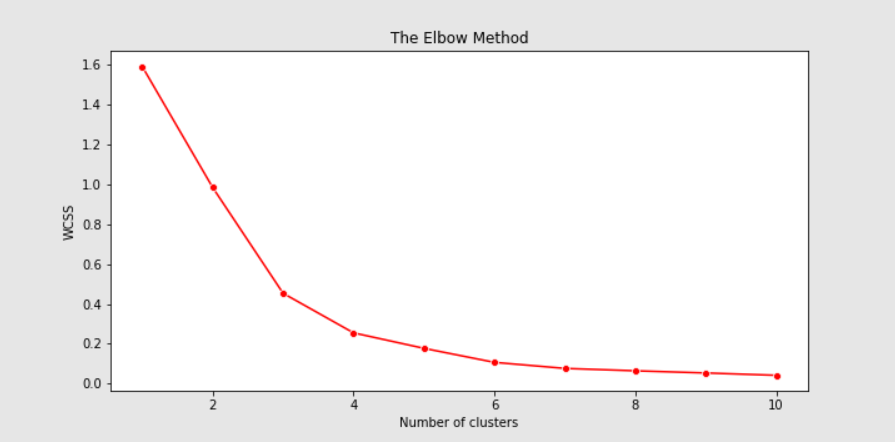


The 5 groups we got were:
```
[['Denmark', 'Iceland', 'Ireland', 'Luxembourg', 'Norway', 'Sweden'],
 ['Croatia',
  'Czechia',
  'Estonia',
  'Greece',
  'Hungary',
  'Latvia',
  'Lithuania',
  'Poland',
  'Slovakia'],
 ['Malta'],
 ['Romania'],
 ['Austria',
  'Belgium',
  'Cyprus',
  'Finland',
  'France',
  'Germany',
  'Italy',
  'Netherlands',
  'Portugal',
  'Slovenia',
  'Spain']]
```



Of course it was kind of weird that Malta and Romania were off in their own groups. You can see here that they were far off from the other groups in the vector space here:

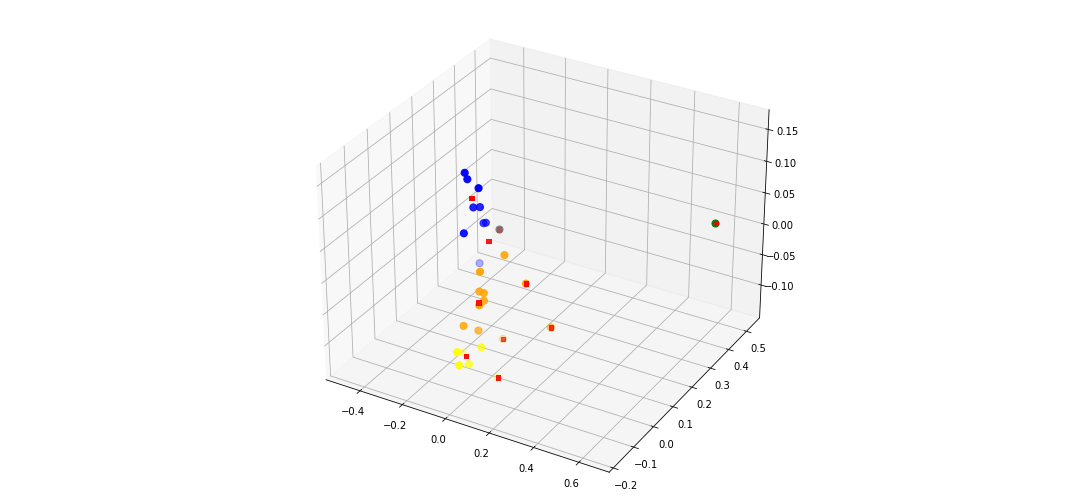

Brown dot and light blue: Malta and Romania
(Its hard to see light blue from this angle)

#### Assumptions

The choice to group the countries as we did was because we did not feel as though we could draw conclusions about a country when comparing it to another country that went through the pandemic in a different context.

# Proposed Model/Simulator

# A Policy and Testing Rate Simulator Using an RNN

> The most potentially vunerable country's public servants and leaders must plan out their best course of precautionary and testing measures. 

# The Problem

We started by trying to figure out how we could take into consideration the start and end dates of various policies that European countries implemented to see their effect on covid numbers. What is quite difficult about this is that there are many varieties of ways that various policies were implemented in respect to covid numbers over time. There were over 40 total policies that countries implemented in different combinations. The problem was complicated because not only were there a variety of combinations, but some countries stopped some policies and then restarted them later. Some policies might be effective in wealthier countries, some might not work if there aren't enough hospital beds, etc. The problem we chose was a little overwhelming.

\

Previous studies (which I found too late) make it clear that for the first wave a "lockdown" is by far the most effective policy. https://www.nature.com/articles/s41586-020-2405-7  

\

But as Europe's covid cases began to drop down in the summer, many countries diverged in their policy implementations. Some countries stopped policies altogether, some countries stopped and restarted, and some started policies for the first time. This was true for lockdown policies.

\

While a lockdown works, there are still more questions. Like is it better to gradually end a set of lockdown policies or to end them in a small timespan? Do attributes of the country such as age and stringency affect policy.

\

While Machine learning is a black box, it can do a good job of considering every single one of the questions we had, and even some we never thought to ask. As a complementary simulation tool it could be practical to have on hand. 


# Why RNN

Though we initally tried various configurations of:
- Facebook Prophet
- SARIMAX
- Neural Net

In order to model our time series data, there was no easy way to incorporate the many and overlapping strategies and responses that countries tried together when looking at the same country's data

\

Because of the RNN structure it is well suited to incorporate the set of policies implemented on a particular day, and use an LSTM to carry forward the possible effect on our output variables.

\

To see why the RNN is well suit for this task, look at this diagram of the typical RNN structure:

\
![stupid missed fork.png](https://miro.medium.com/max/3172/1*mHimR6ok4bAEYhKESwhdrg.png)


Where X is in this picture we can pass in a vector of the data about the country for that single timestep. We can then pass that through a unit/weights (in this case I will try to use an LSTM) to get an output which is an estimate of the covid related stats for the country. This is repeated with input from the next timestep and carry over from the previous timestep.

\
The main advantage of this model is that we can be creative about what we include in the X vector and the process of machine learning will figure out many of the nuances.

\

The h in this diagram will either be a LSTM or a GRU unit. An LSTM is structured like this:
![stupid missed fork.png](https://www.researchgate.net/profile/Xiaofeng-Yuan-4/publication/331421650/figure/fig2/AS:771405641695233@1560928845927/The-structure-of-the-LSTM-unit.png)
The LSTM allows for past Response_measures, covid numbers, and information about the country to carry forward in the 'memory' (LSTM stands for long short-term memory) to affect later predictions without that memory fizzling out due to vanishing gradients.

\

The RNN is well suited for our problem because it is flexible in its input and it fulfills the conditions of the problem.

\
This suggestion to use an RNN for timeseries is also not without precedent.  

https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network 

https://www.tensorflow.org/tutorials/structured_data/time_series#advanced_autoregressive_model 

\

But the typical implementation will be slightly modified for the purpose of considering Response measures. (note, might use pytorch because of need for iterative process in testing custom structure)

\

The structure will look like this(just imagine the image doesn't look hacked together in MSpaint):



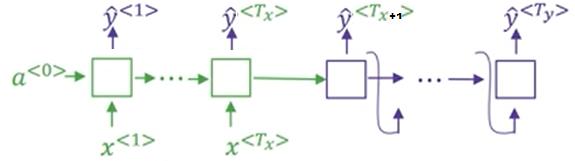

I'll explain the specifics in the implementation section

# Implementation

Using an RNN to predict the number of covid cases from the attributes of the country, past timeseries data, and when+what response measures were implemented, we should theoretically be able to simulate parameters of interest on future timesteps   would allow.`

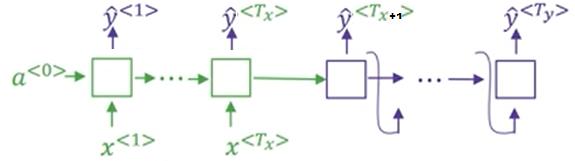

the vector X would be represented by the numerical values (T/F being 1/0) of the timestep's row in a table like this (though much longer):

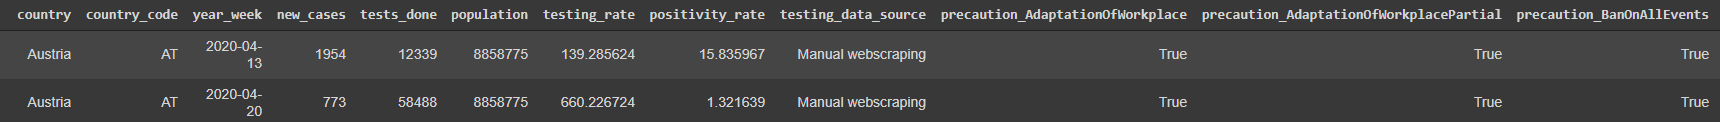

the vector `y_hat` would include information like the `death_rate`, `case_rate`, and new `R_0` for the next day

\

the parameters included in the vector `y_hat` should also be included in `x`. This is because all the previous ordered time series data will be an input for the model to make future predictions -- and once our model gets to the end of the provided time series this RNN structure deviates from how RNNs are normally implemented in a way that requires that the `y` vector be inside the `x` vector.

\

Say we have a vector X: `[gdpPerCapita, density, covidNums, policy_1, policy_2, policy_3]`. Our user would input these X vectors for the timestamps that they had access to. (note our RNN model would be trained on these kinds of X vector inputs for other country's data). The user could then set a timestamp that they wanted the model to predict out to beyond latest timestamp. 

\
Once past that timestamp elements like 
- `[gdpPerCapita, density]` would be passed into the next X vector as they stay the same for the country
- `[policy_1,policy_2]` would be manually set by the user looking to simulate different predictions based on their policy plans
- `[covidNums]` would be calculated in the previous time step, carried over and added into the X vector for the next timestep

the `y` values like `[covidNums]` being carried over are depicted like this in the structure diagram:


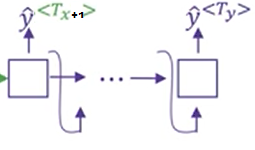

Ultimately what a public servant could do with this model is:
1. Input : Covid Data, Policy Data, and Static Country Data
2. Set date out to which they would want to simulate
3. Set the policies for each time step in the form of a vector of `1` and `0`
   - The policy input is flexible, for a time step vector `[policy_1,policy_2,policy_3]` you could set the policy vector to be `[0,0,1]` for the first 20 timesteps, and `[1,1,1]` for the next 10, and then alternate between `[1,0,0]` and `[0,0,0]` for the rest of othe time. (even if this is non sensical)
4. run the model and observe what that time sensitive policy plan might lead to in terms of covid cases


# RNN Conclusion

I have no idea if I have been able finish this in time. I came up with the idea after spending days exploring the covid data from the Datathon extensively. I think it could be meaningfully useful in helping countries deal with pandemics, and I think it is kind of novel. 

\
I intend to keep on working on this idea post Datathon until the model is complete. I want to add more data from past pandemics if there is enough out there and experiment with more layered RNN models

### Fun Mistakes

1. Read the meta data carefully
  - The response measure ClosePub $\not=$ close the pubs
  - A european alcohol modeling project is not as feasable as previously thought
  - I just thought this was funny

2. Don't spend so much time making pretty maps if they can't be used (;﹏;)
  - The NUTS or Nomenclature of Territorial Units for Statistics column in the notification ecdc df is really cool for making maps that have region specific stats
  - have to use downloaded shape data and plot in geopandas
  - Dealing with the level 1, 2, 3 nuances of NUTs and other inconsistencies is a headache
  - but dam if it's not pretty

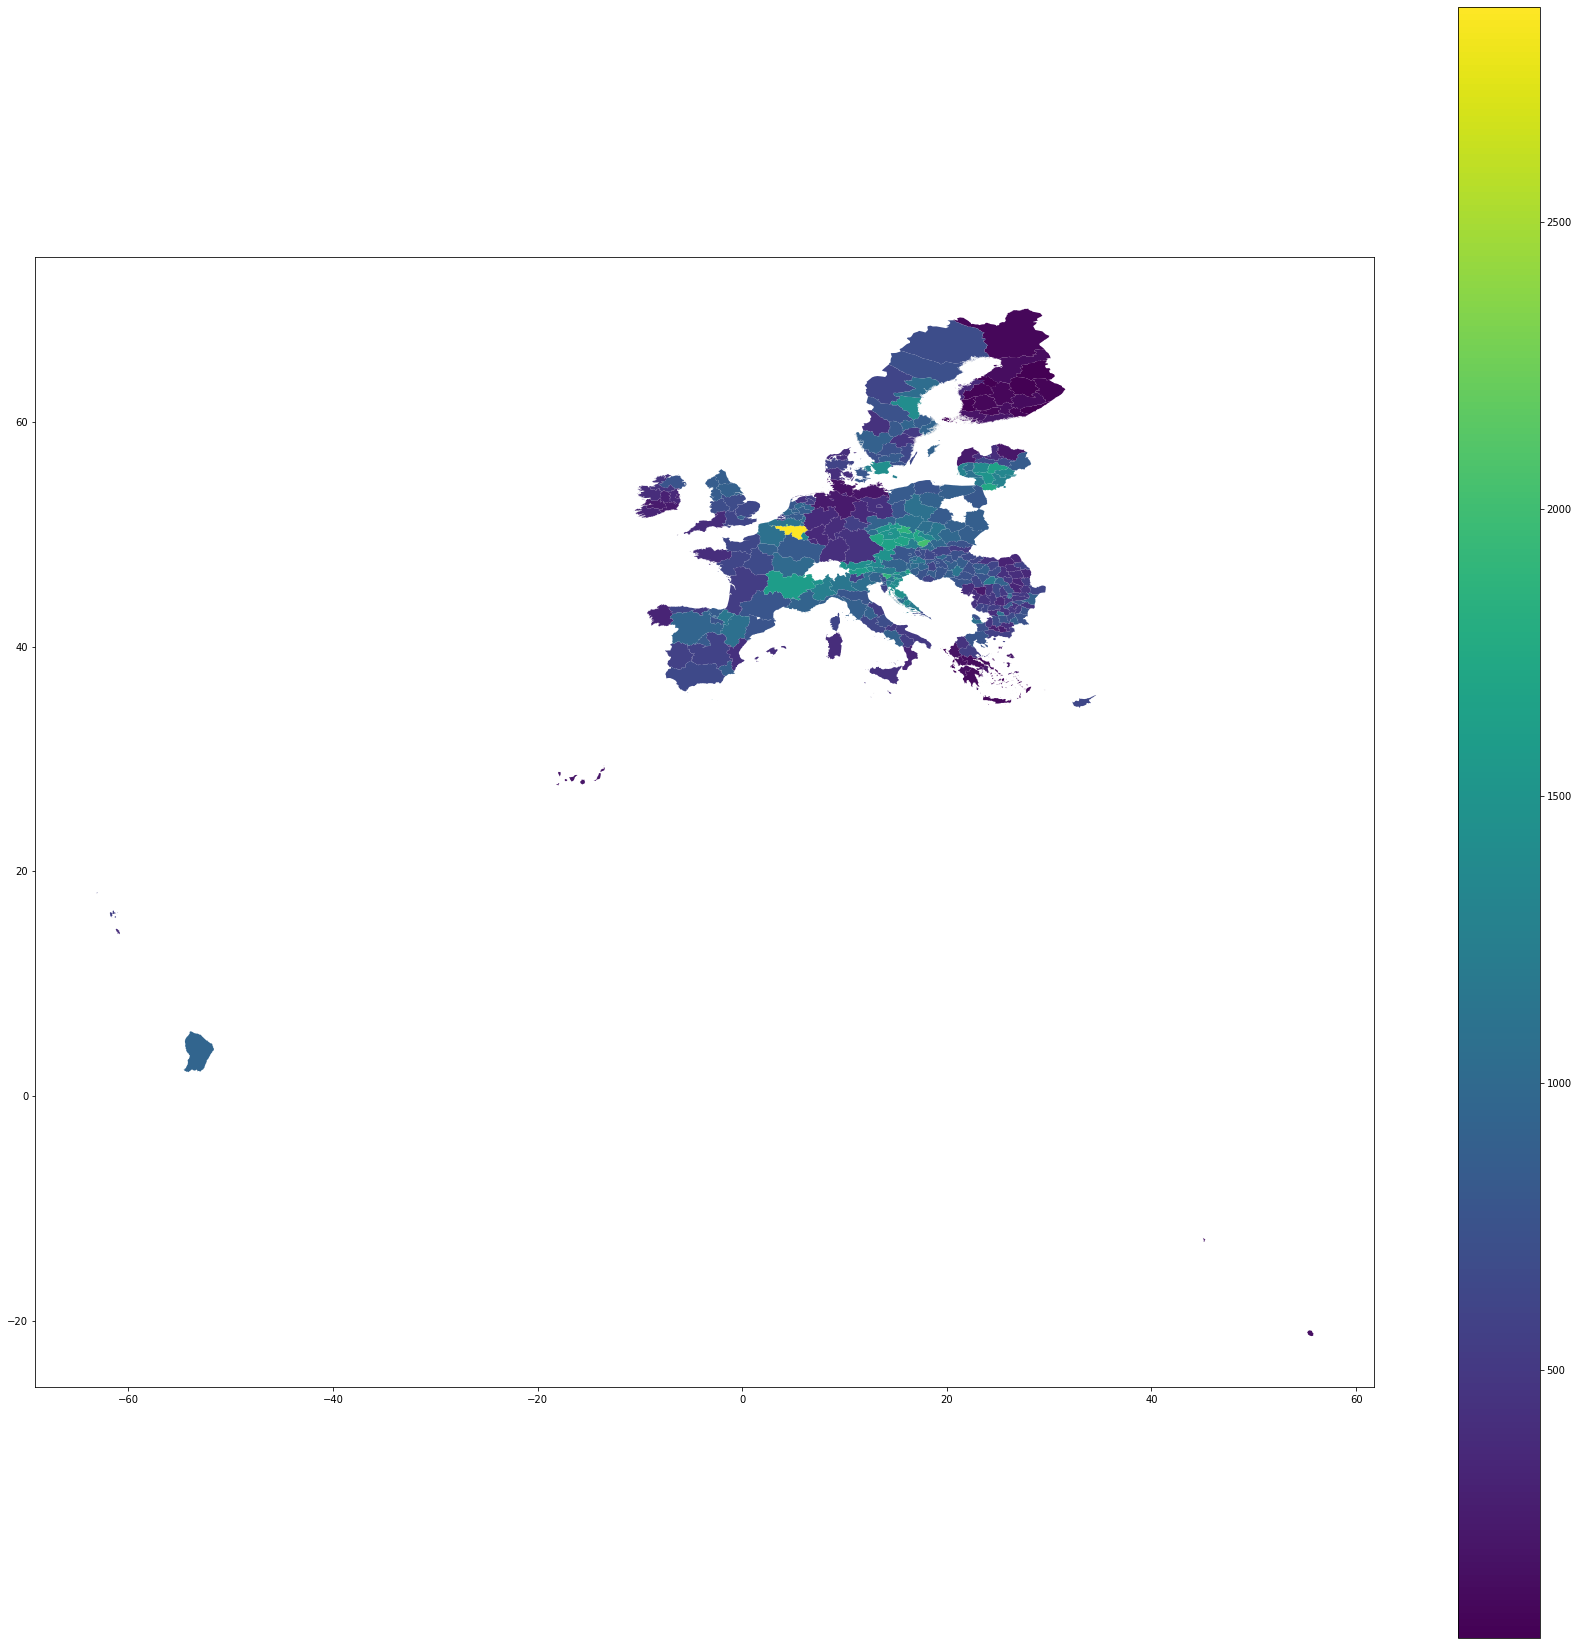

Portugal, scotland, and the baltics are in there, but it's really annoying to convert the NUTS codes